# Variance and Bias Detection

These are examples of learning curves used to detect variance and bias in Pytorch models.  

## Variance Detection

Here's an example of a learning curve for a high variance Pytorch model.  The data set and neural network model architecture were suggested by [ChatGPT](https://chat.openai.com/) on 26 Feburary 2023 (using "ChatGPT Feb 13 version").

When prompted for a data set and neural network architecture that overfits the data, ChatGPT suggested two hidden layers with 1024 and 512 nodes, along with ReLU activation and dropout.  Training with 500 data points of the [MNIST data set](http://yann.lecun.com/exdb/mnist/) while using 100 epochs for training was also recommended.  Below is the implementation of that model and the resulting learning curve.

The larger number of parameters and extra layers, compared to the example in the [gpu-minibatch.ipynb](https://github.com/AlexGose/learning-curve/blob/main/notebooks/gpu_minibatch.ipynb) notebook, seemed to help induce over-fitting. However, the leveling off of the testing accuracy is clearer, given the random number seeds chosen below, after increasing the number of training data points to 800 and avoiding the use of dropout.  A careful analysis of the learning curves could be done by conducting a test to determine if the leveling off is statistically significant.

In [ ]:
!pip list

In [1]:
# Packages to install on Google Colab
!pip install --upgrade skorch scikit-learn # need scikit-learn v1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 KB 8.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LearningCurveDisplay
from sklearn.metrics import accuracy_score, make_scorer, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from skorch import NeuralNetClassifier, NeuralNetBinaryClassifier
import matplotlib.pyplot as plt

In [12]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

In [13]:
train_data = torchvision.datasets.MNIST('.',train=True, download=True)
test_data = torchvision.datasets.MNIST('.',train=False, download=True)

In [14]:
height=train_data.data.shape[1]
width=train_data.data.shape[2]
num_pixels = height*width

In [15]:
X_train = train_data.data.view(-1,num_pixels).detach().numpy().astype(np.float32) / 255
X_test = test_data.data.view(-1,num_pixels).detach().numpy().astype(np.float32) / 255
X = np.vstack((X_train,X_test))

In [16]:
y_train = train_data.targets.detach().numpy().astype(np.int64)
y_test = test_data.targets.detach().numpy().astype(np.int64)
y = np.concatenate((y_train, y_test))

In [17]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [18]:
class ClassifierModule(nn.Module):
    def __init__(self, num_units1=150, num_units2=100):
        super().__init__()
        self.dense0 = nn.Linear(num_pixels, num_units1)
        self.nonlin = nn.ReLU()
        self.dense1 = nn.Linear(num_units1, num_units2)
        self.output = nn.Linear(num_units2,10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, X, **kwargs):
        X = self.dense0(X)
        X = self.nonlin(X)
        #X = self.dropout(X)
        X = self.dense1(X)
        X = self.nonlin(X)
        #X = self.dropout(X)
        X = self.output(X)
        return X

In [19]:
net = NeuralNetClassifier(
    ClassifierModule,
    module__num_units1=1024,
    module__num_units2=512,
    max_epochs=100,
    criterion=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    device=device,
    batch_size=128,
    warm_start=True,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    verbose=0
)

The learning curves below show a sizeable gap between the testing and training accuracy towards the right of the plot.  Due to the leveling off of both curves, more training data is unlikely to close the gap.  If the desired testing accuracy is higher than 85 percent, for example 95 percent, then this learning curve plot suggests the model has too much variance.

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Text(0.5, 1.0, 'Learning Curve')

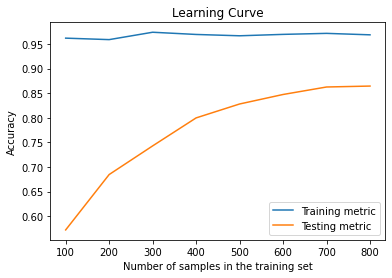

In [20]:
lcd = LearningCurveDisplay.from_estimator(net, X, y, score_type='both', 
                std_display_style=None, score_name='Accuracy', 
    scoring=make_scorer(accuracy_score),
    train_sizes=np.arange(100,801,100))
lcd.ax_.set_title('Learning Curve')

In [21]:
lcd.ax_.get_figure().savefig('variance.png', facecolor='white', transparent=False)

## Bias

Here's an example of a learning curve for a high bias Pytorch model.  The [data set](https://archive.ics.uci.edu/ml/datasets/mushroom) is used to predict whether mushrooms are edible or poisonous based on over 20 categorical features, but only a few features are selected in order to induce bias in the model.  A conveniently formatted CSV file is downloaded below from the datahub.io website.

In [22]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

In [23]:
!wget https://datahub.io/machine-learning/mushroom/r/mushroom.csv

--2023-03-06 15:00:17--  https://datahub.io/machine-learning/mushroom/r/mushroom.csv
Resolving datahub.io (datahub.io)... 104.21.40.221, 172.67.157.38, 2606:4700:3033::6815:28dd, ...
Connecting to datahub.io (datahub.io)|104.21.40.221|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/machine-learning/mushroom/mushroom_csv/data/652524e2d0176fbc16354df92fe91fcd/mushroom_csv.csv [following]
--2023-03-06 15:00:18--  https://pkgstore.datahub.io/machine-learning/mushroom/mushroom_csv/data/652524e2d0176fbc16354df92fe91fcd/mushroom_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 104.21.40.221, 172.67.157.38, 2606:4700:3033::6815:28dd, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|104.21.40.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 379652 (371K) [text/csv]
Saving to: ‘mushroom.csv’

mushroom.csv        100%[===================>] 370.75K  --.-KB/s    in 0.007s  

2023-03-06 1

In [24]:
shroom_data = pd.read_csv('mushroom.csv', low_memory=False)

In [25]:
for col in shroom_data.columns: # scale the data
    values = list(shroom_data[col].unique())
    shroom_data[col] = np.vectorize(lambda x: values.index(x))(shroom_data[col])
    if shroom_data[col].max() > 0:
        shroom_data[col] = shroom_data[col] / shroom_data[col].max()

In [26]:
X = shroom_data.iloc[:,:-1].values.astype(np.float32)
y = shroom_data.iloc[:,-1].values.astype(np.float32)

In [27]:
# only a few columns are selected from the input data
cols_selected = [5,7,17]
num_cols = len(cols_selected)
X = X[:,cols_selected].reshape((-1,num_cols))

In [28]:
class MushroomClassifier(nn.Module):
    def __init__(self, num_units=5):
        super().__init__()
        self.dense0 = nn.Linear(num_cols, num_units)
        self.nonlin = nn.ReLU()
        self.dense1 = nn.Linear(num_units,10)
        self.output = nn.Linear(10,1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, X, **kwargs):
        X = self.dense0(X)
        X = self.nonlin(X)
        X = self.dropout(X)
        X = self.dense1(X)
        X = self.nonlin(X)
        X = self.dropout(X)
        X = self.output(X)
        return X

In [29]:
net = NeuralNetBinaryClassifier(
    MushroomClassifier,
    module__num_units=20,
    max_epochs=20,
    optimizer=torch.optim.Adam,
    device='cuda',
    batch_size=50,
    warm_start=True,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    verbose=0
)

Suppose the desired performance is above 85% testing accuracy, then both lines end up well below this mark towards the right of the plot below.  This suggests bias in the model.

The training metric is no longer decreasing towards the right of the plot.  Similarly, the test metric is relatively stable in this region as well.  This suggests additional data may not eliminate the bias, but a statistical test could be conducted to determine if the training curve is non-decreasing and the testing curve is non-increasing.



Text(0.5, 1.0, 'Learning Curve')

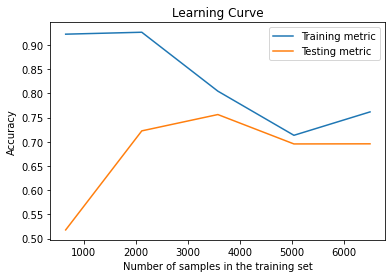

In [30]:
lcd = LearningCurveDisplay.from_estimator(net, X, y, score_type='both', 
                std_display_style=None, score_name='Accuracy', 
                scoring=make_scorer(accuracy_score))
lcd.ax_.set_title('Learning Curve')

In [31]:
lcd.ax_.get_figure().savefig('bias.png', facecolor='white', transparent=False)